# Read Data

In [67]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

# for LR
import statsmodels.api as sm
from sklearn.model_selection import KFold
import random

In [68]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [69]:
%%time
train_data = pd.read_csv('/Users/josephcolaco/customer_revenue_prediction/data/train.csv')
test_data = pd.read_csv('/Users/josephcolaco/customer_revenue_prediction/data/test.csv')
print('Shape of test data is', test_data.shape)
print('Shape of train data is',train_data.shape)

<string>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.


Shape of test data is (804684, 12)
Shape of train data is (903653, 12)
CPU times: user 21.6 s, sys: 3.29 s, total: 24.9 s
Wall time: 25.5 s


# Data Cleaning

To do for data cleaning
- json to dataframe columns
- format various data types
- need to format the date field
- visitNumber as int
- format visitStartTime
- format visits
- format campaignCode
- deal with nulls
- drop columns that are not needed

### Convert json columns to df format

In [70]:
%%time
def json_to_lst(model_data, json_cols):
    for column in json_cols:
        model_data = model_data.join(pd.DataFrame(
            model_data.pop(column).apply(pd.io.json.loads).values.tolist(), index=model_data.index)) 
    
    return model_data

CPU times: user 11 µs, sys: 12 µs, total: 23 µs
Wall time: 29.1 µs


In [71]:
%%time
json_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
train_data_v1 = json_to_lst(train_data, json_cols)
test_data_v1 = json_to_lst(test_data, json_cols)

CPU times: user 1min 17s, sys: 32.7 s, total: 1min 50s
Wall time: 1min 54s


The 'adwordsClickInfo' feild is a dictionary. Let's change that to a dataframe columns.

In [72]:
%%time
concat_df = pd.DataFrame(train_data_v1['adwordsClickInfo'].tolist())
train_data_v2 = train_data_v1.drop(columns = ['adwordsClickInfo'])
train_data_v3 = pd.concat([train_data_v2,concat_df], axis=1)

CPU times: user 13.6 s, sys: 22.5 s, total: 36.1 s
Wall time: 41.3 s


### Drop Columns with No Data

In [73]:
print('Shape of train data version 3 is:', train_data_v3.shape)
train_data_v3.head(3)

Shape of train data version 3 is: (903653, 56)


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,bounces,hits,newVisits,pageviews,transactionRevenue,visits,adContent,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source,adNetworkType,criteriaParameters,gclId,isVideoAd,page,slot,targetingCriteria
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN


Data is not available in several columns in the dataset. These columns will be dropped from the dataframe. 'visits' field will also be deleted as it has only one value in the column ('1').

In [74]:
train_data_v4 = train_data_v3.drop(columns = ['browserSize', 'browserVersion', 'flashVersion', 'language','mobileDeviceBranding', 
                             'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel', 
                              'mobileInputSelector', 'operatingSystemVersion', 'screenColors', 'screenResolution',
                             'cityId', 'latitude', 'longitude', 'networkLocation', 'targetingCriteria', 
                                              'criteriaParameters', 'visits', 'socialEngagementType'])

print('Shape of train_data version 4 is:', train_data_v4.shape)

Shape of train_data version 4 is: (903653, 36)


### Adjusting Data Types

In [75]:
train_data_v4.dtypes

channelGrouping       object
date                   int64
fullVisitorId         object
sessionId             object
visitId                int64
visitNumber            int64
visitStartTime         int64
browser               object
deviceCategory        object
isMobile                bool
operatingSystem       object
city                  object
continent             object
country               object
metro                 object
networkDomain         object
region                object
subContinent          object
bounces               object
hits                  object
newVisits             object
pageviews             object
transactionRevenue    object
adContent             object
campaign              object
campaignCode          object
isTrueDirect          object
keyword               object
medium                object
referralPath          object
source                object
adNetworkType         object
gclId                 object
isVideoAd             object
page          

Format the date field:

In [76]:
train_data_v4['date'] = pd.to_datetime(train_data_v4['date'], format='%Y%m%d')

Other format changes:
- hits to int
- newVisits to int
- pageviews to int
- transactionRevenue to float64
- page to int
- bounces to int
- isTrueDirect to bool

In [77]:
train_data_v4['transactionRevenue'] = train_data_v4['transactionRevenue'].fillna(1).astype('float64')
train_data_v4['hits'] = train_data_v4['hits'].fillna(0).astype('int64')
train_data_v4['newVisits'] = train_data_v4['newVisits'].fillna(0).astype('int64')
train_data_v4['pageviews'] = train_data_v4['pageviews'].fillna(0).astype('int64')
train_data_v4['page'] = train_data_v4['page'].fillna(0).astype('int64')
train_data_v4['bounces'] = train_data_v4['bounces'].fillna(0).astype('int64')
train_data_v4['isTrueDirect'] = train_data_v4['isTrueDirect'].fillna('False').astype('bool')
train_data_v4['isVideoAd'] = train_data_v4['isVideoAd'].fillna('False').astype('bool')

In [78]:
train_data_v4.dtypes

channelGrouping               object
date                  datetime64[ns]
fullVisitorId                 object
sessionId                     object
visitId                        int64
visitNumber                    int64
visitStartTime                 int64
browser                       object
deviceCategory                object
isMobile                        bool
operatingSystem               object
city                          object
continent                     object
country                       object
metro                         object
networkDomain                 object
region                        object
subContinent                  object
bounces                        int64
hits                           int64
newVisits                      int64
pageviews                      int64
transactionRevenue           float64
adContent                     object
campaign                      object
campaignCode                  object
isTrueDirect                    bool
k

### Deal with Nulls

In [79]:
train_data_v4.isnull().sum()

channelGrouping            0
date                       0
fullVisitorId              0
sessionId                  0
visitId                    0
visitNumber                0
visitStartTime             0
browser                    0
deviceCategory             0
isMobile                   0
operatingSystem            0
city                       0
continent                  0
country                    0
metro                      0
networkDomain              0
region                     0
subContinent               0
bounces                    0
hits                       0
newVisits                  0
pageviews                  0
transactionRevenue         0
adContent             892707
campaign                   0
campaignCode          903652
isTrueDirect               0
keyword               502929
medium                     0
referralPath          572712
source                     0
adNetworkType         882193
gclId                 882092
isVideoAd                  0
page          

fill all object column nans with '(not set)'

In [80]:
for i in train_data_v4.columns:
    if train_data_v4[i].isnull().sum() > 0:
        train_data_v4[i] = train_data_v4[i].fillna('(not set)')

Replace all 'not available in demo dataset' to '(not set)'

In [81]:
train_data_v4 = train_data_v4.replace(['not available in demo dataset'], ['(not_set)'])

formating visitStartTime:

In [82]:
train_data_v4['visitStartTime'] = train_data_v4['visitStartTime'].apply(lambda x: dt.datetime.utcfromtimestamp(float(x)))

In [83]:
train_data_v4.isnull().sum().sum()

0

In [84]:
train_data_v4.shape

(903653, 36)

# Feature Engineering

In [85]:
train_data_v4 = train_data_v4.assign(
    logtransactionRevenue = np.log(train_data_v4.transactionRevenue))
train_data_v4 = train_data_v4.drop(columns=['transactionRevenue'])

Make day of week, month name and year columns from the date

In [86]:
train_data_v4['dayNameDate'] = train_data_v4['date'].dt.day_name()
train_data_v4['monthDate'] = train_data_v4['date'].dt.month
train_data_v4['yearDate'] = train_data_v4['date'].dt.year
train_data_v4['dayDate'] = train_data_v4['date'].dt.day

In [87]:
train_data_v4['madePurchase'] = np.where(train_data_v4['logtransactionRevenue'] > 0, 1, 0)

In [88]:
train_data_v4['visitHour'] = train_data_v4['visitStartTime'].dt.hour

In [89]:
train_data_v4.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,deviceCategory,isMobile,operatingSystem,city,continent,country,metro,networkDomain,region,subContinent,bounces,hits,newVisits,pageviews,adContent,campaign,campaignCode,isTrueDirect,keyword,medium,referralPath,source,adNetworkType,gclId,isVideoAd,page,slot,logtransactionRevenue,dayNameDate,monthDate,yearDate,dayDate,madePurchase,visitHour
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,2016-09-02 15:33:05,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1,1,1,1,(not set),(not set),(not set),True,(not provided),organic,(not set),google,(not set),(not set),True,0,(not set),0.0,Friday,9,2016,2,0,15
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,2016-09-03 05:22:27,Firefox,desktop,False,Macintosh,(not_set),Oceania,Australia,(not_set),dodo.net.au,(not_set),Australasia,1,1,1,1,(not set),(not set),(not set),True,(not provided),organic,(not set),google,(not set),(not set),True,0,(not set),0.0,Friday,9,2016,2,0,5
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,2016-09-03 01:16:26,Chrome,desktop,False,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1,1,1,1,(not set),(not set),(not set),True,(not provided),organic,(not set),google,(not set),(not set),True,0,(not set),0.0,Friday,9,2016,2,0,1
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,2016-09-03 05:40:13,UC Browser,desktop,False,Linux,(not_set),Asia,Indonesia,(not_set),unknown.unknown,(not_set),Southeast Asia,1,1,1,1,(not set),(not set),(not set),True,google + online,organic,(not set),google,(not set),(not set),True,0,(not set),0.0,Friday,9,2016,2,0,5
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,2016-09-02 13:23:20,Chrome,mobile,True,Android,(not_set),Europe,United Kingdom,(not_set),unknown.unknown,(not_set),Northern Europe,1,1,0,1,(not set),(not set),(not set),True,(not provided),organic,(not set),google,(not set),(not set),True,0,(not set),0.0,Friday,9,2016,2,0,13


# EDA

In [90]:
def plot_hist(x, bins, xlabel, ylabel, title):
#     plt.style.use('ggplot')
    plt.style.use('seaborn')
    plt.hist(x, bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [91]:
def plot_scatter(x, y,xlabel, ylabel, title):
    plt.style.use('seaborn')
    plt.scatter(x, y, alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [92]:
def plot_sns_scatter(data, x, y, hue):
    sns.lmplot(x=x, y=y, data=data, 
               fit_reg=False, legend=False, hue = hue)

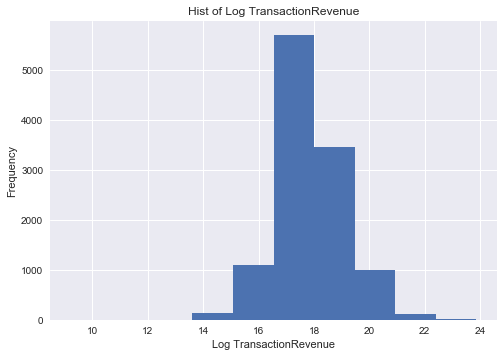

In [93]:
plot_hist(train_data_v4['logtransactionRevenue'][train_data_v4['logtransactionRevenue'] > 0], 10, 
          'Log TransactionRevenue', 'Frequency', 'Hist of Log TransactionRevenue')

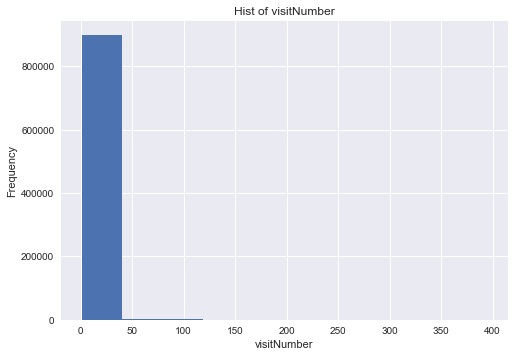

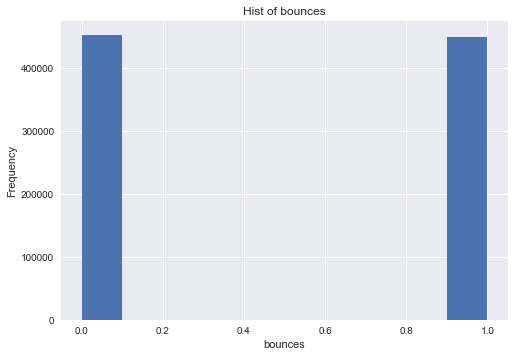

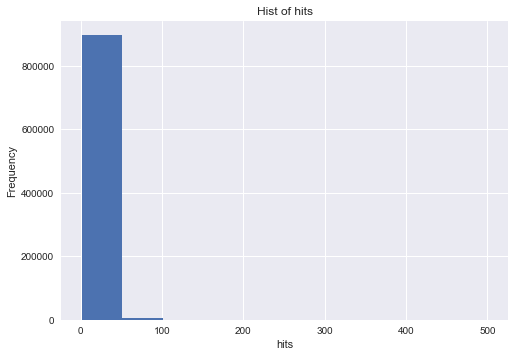

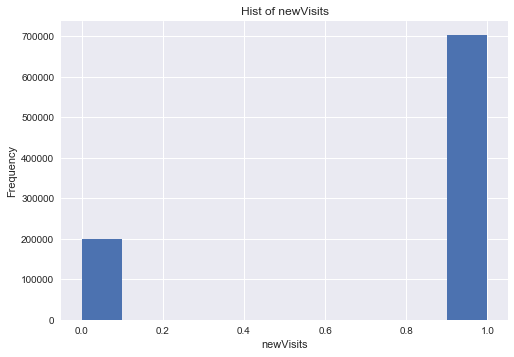

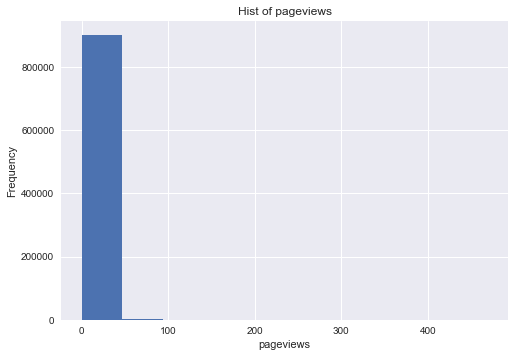

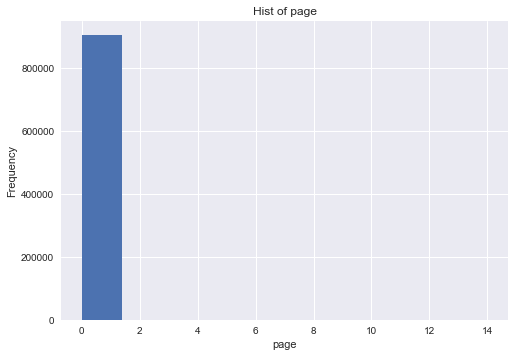

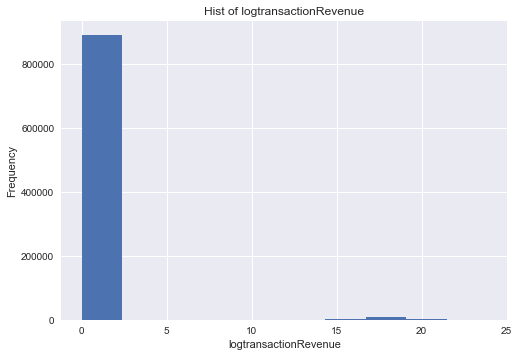

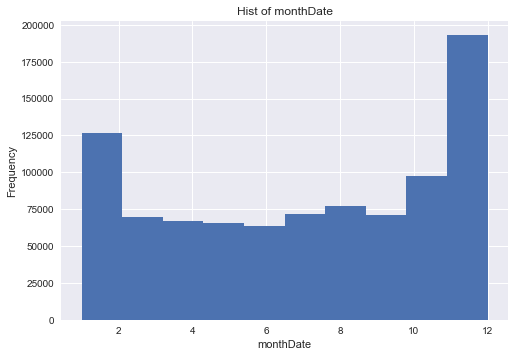

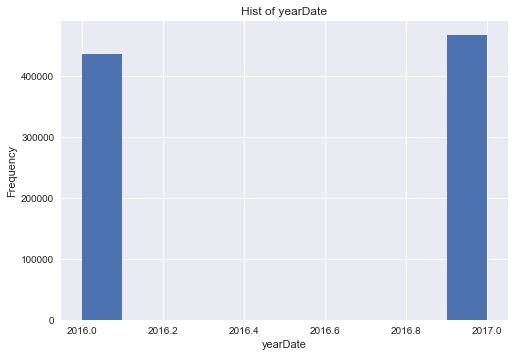

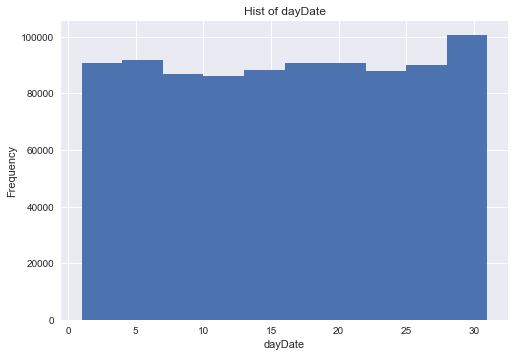

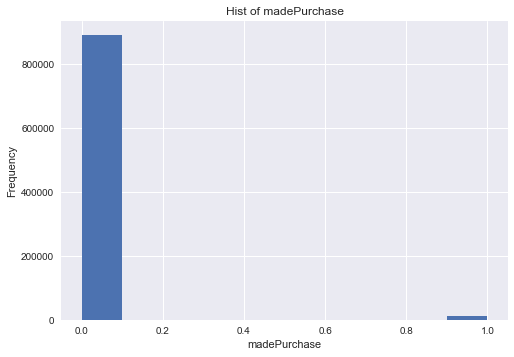

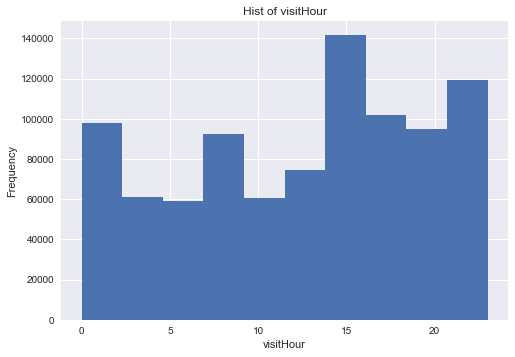

In [94]:
numeric_cols = train_data_v4.select_dtypes(include='number').columns
for i in numeric_cols:
    if i != 'visitId':
        plot_hist(train_data_v4[i], 10, 
          str(i), 'Frequency', 'Hist of ' + str(i))

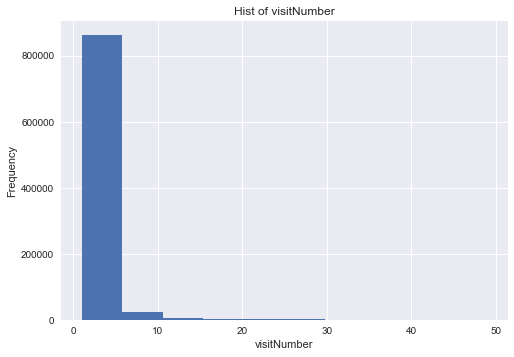

In [95]:
plot_hist(train_data_v4['visitNumber'][train_data_v4['visitNumber'] < 50], 10, 
          'visitNumber', 'Frequency', 'Hist of visitNumber')

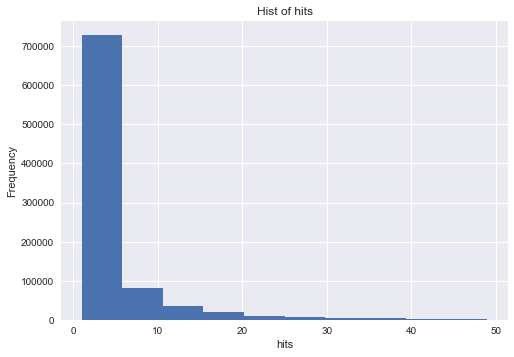

In [96]:
plot_hist(train_data_v4['hits'][train_data_v4['hits'] < 50], 10, 
          'hits', 'Frequency', 'Hist of hits')

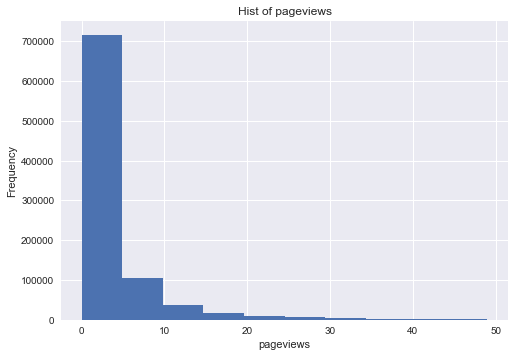

In [97]:
plot_hist(train_data_v4['pageviews'][train_data_v4['pageviews'] < 50], 10, 
          'pageviews', 'Frequency', 'Hist of pageviews')

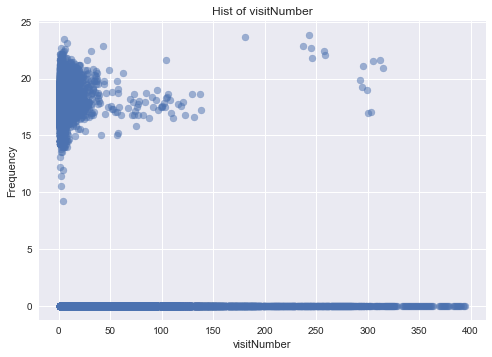

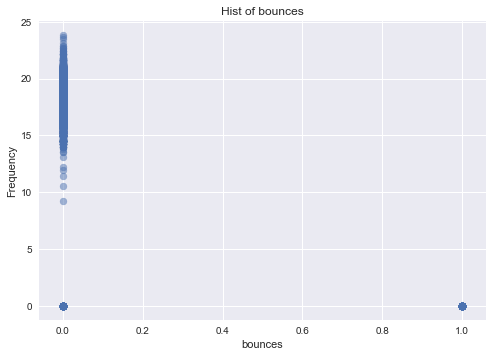

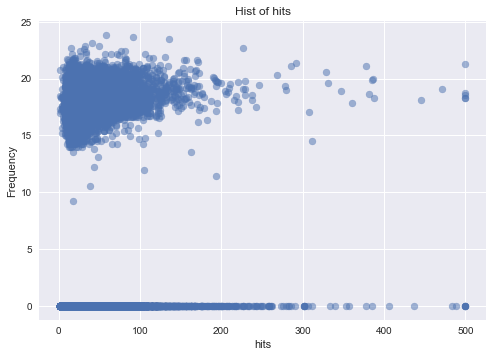

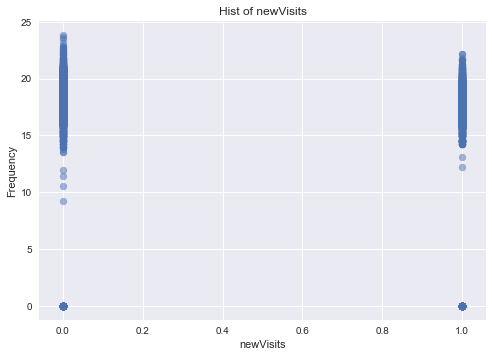

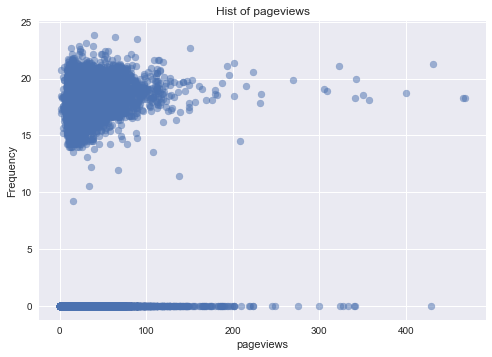

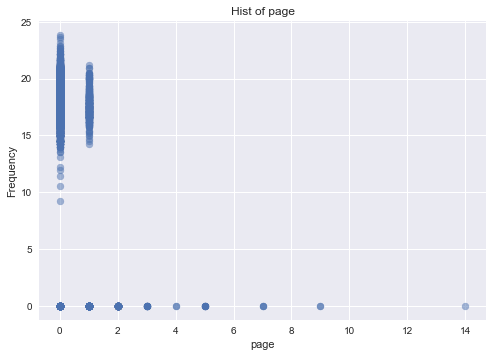

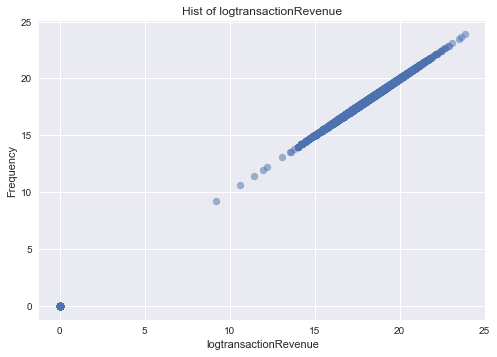

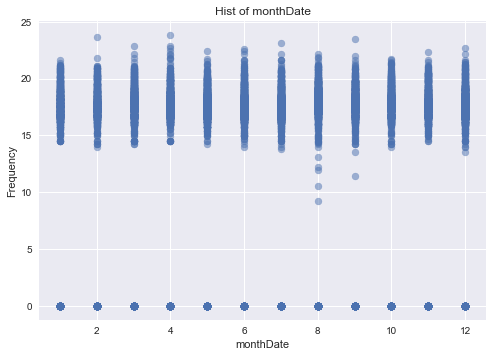

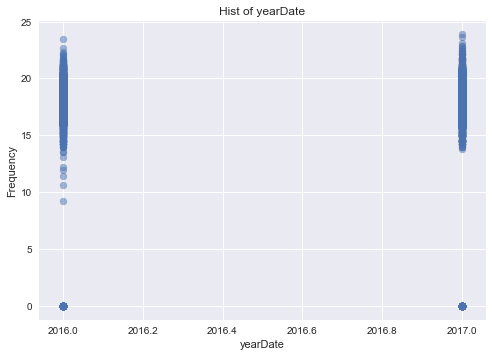

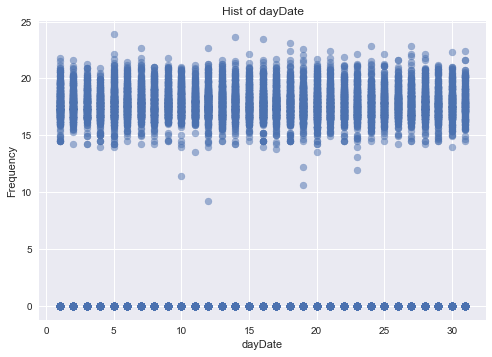

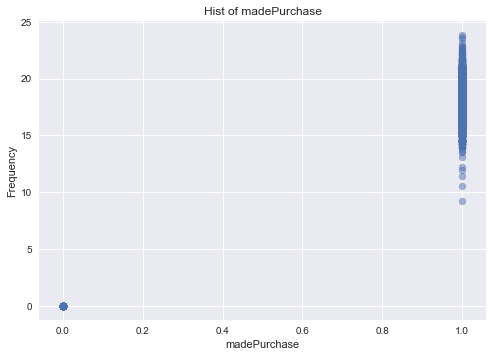

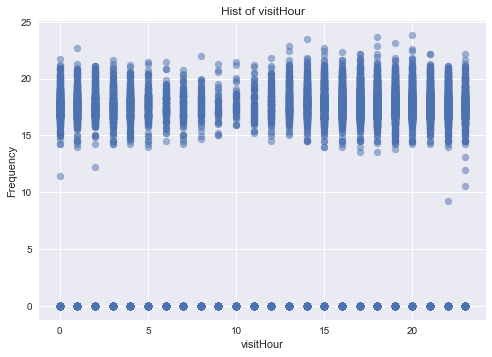

In [98]:
for i in numeric_cols:
    if i != 'visitId':
        plot_scatter(train_data_v4[i], train_data_v4['logtransactionRevenue'], 
          str(i), 'Frequency', 'Hist of ' + str(i))

In [99]:
numeric_data = train_data_v4.select_dtypes(include='number')
corr_LTR = pd.DataFrame(
    numeric_data.corrwith(numeric_data['logtransactionRevenue'], axis=0, drop=False), columns = ['corr'])
corr_LTR.sort_values(by='corr', ascending=False)

,corr
logtransactionRevenue,1.000000
madePurchase,0.997703
pageviews,0.400732
hits,0.378804
visitHour,0.026981
visitNumber,0.023666
page,0.010931
visitId,0.010491
yearDate,0.007612
dayDate,-0.000794


In [100]:
train_data_v4.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'browser', 'deviceCategory',
       'isMobile', 'operatingSystem', 'city', 'continent', 'country', 'metro',
       'networkDomain', 'region', 'subContinent', 'bounces', 'hits',
       'newVisits', 'pageviews', 'adContent', 'campaign', 'campaignCode',
       'isTrueDirect', 'keyword', 'medium', 'referralPath', 'source',
       'adNetworkType', 'gclId', 'isVideoAd', 'page', 'slot',
       'logtransactionRevenue', 'dayNameDate', 'monthDate', 'yearDate',
       'dayDate', 'madePurchase', 'visitHour'],
      dtype='object')

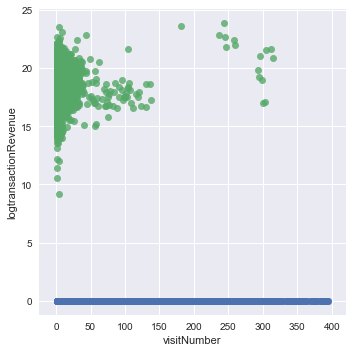

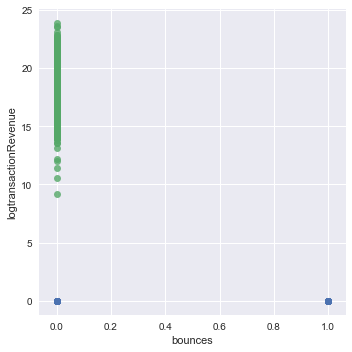

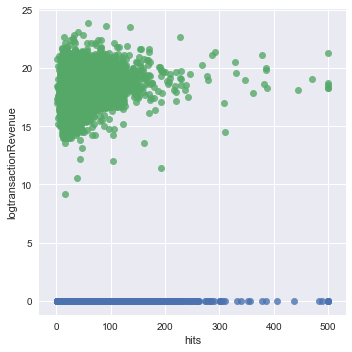

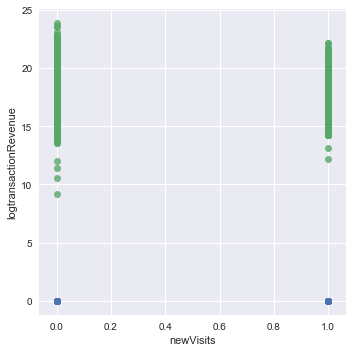

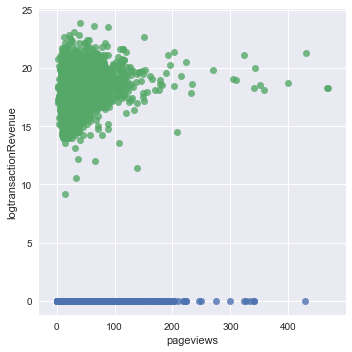

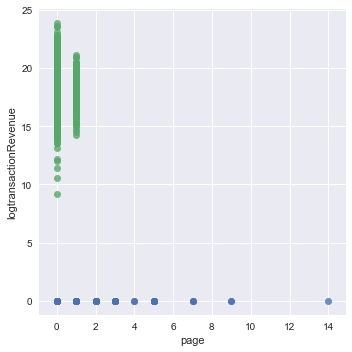

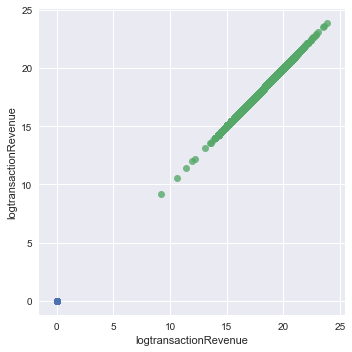

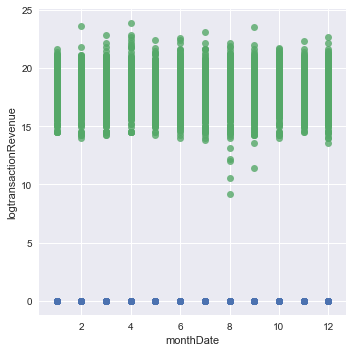

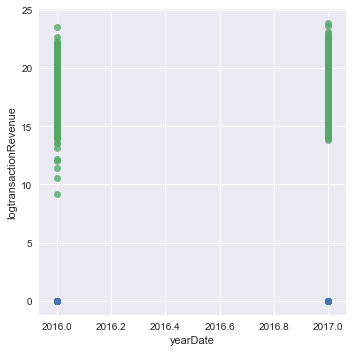

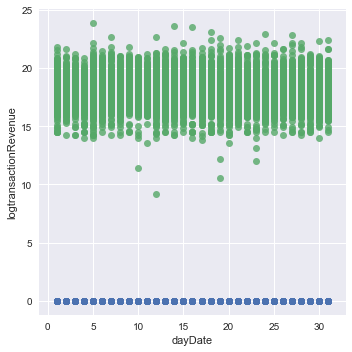

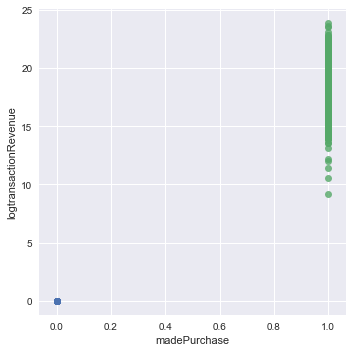

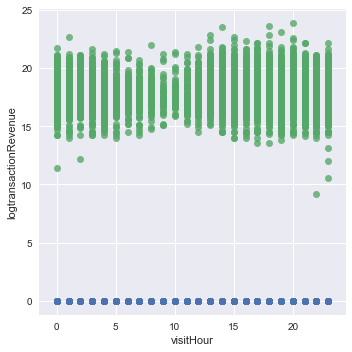

In [37]:
# for i in numeric_cols:
#     if i != 'visitId':
#         plot_sns_scatter(train_data_v4, i, 'logtransactionRevenue', 'madePurchase')

In [101]:
def plot_cat_bar(data, col, title):
    col_value_counts = pd.DataFrame(data[col].value_counts())
    plt.bar(col_value_counts.index, col_value_counts[col])
    plt.title(title)
    plt.show()

channelGrouping


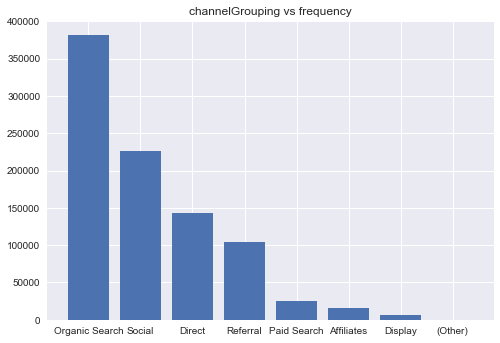

deviceCategory


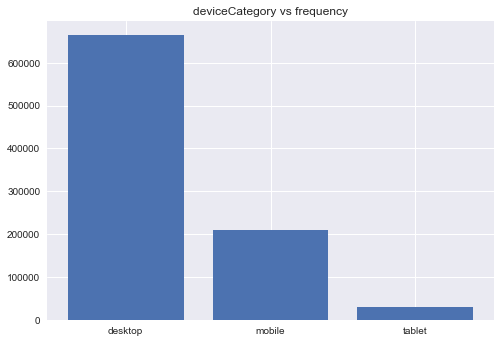

operatingSystem


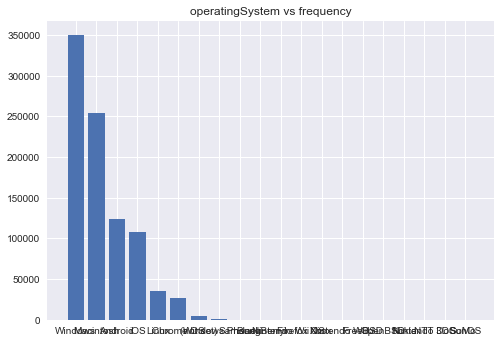

continent


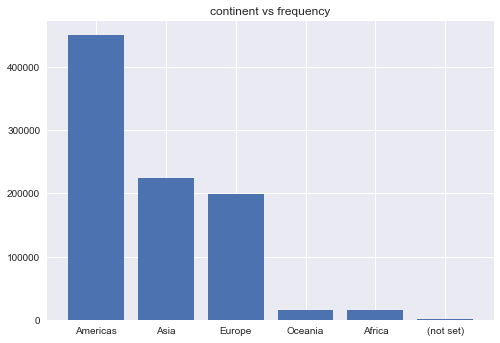

subContinent


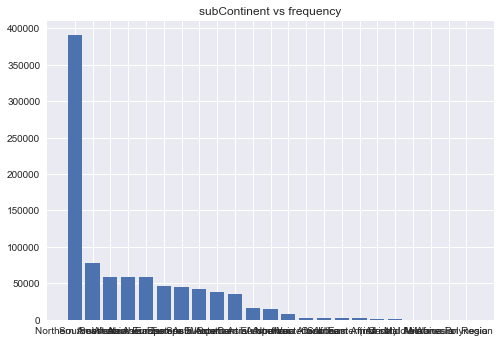

adContent


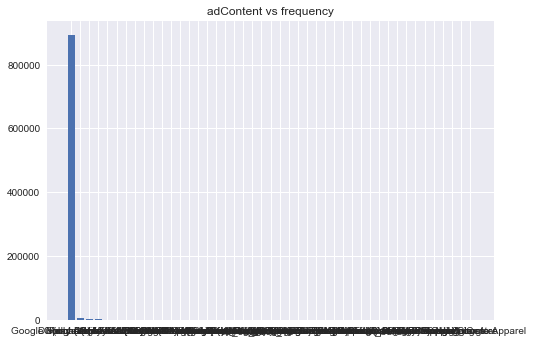

campaign


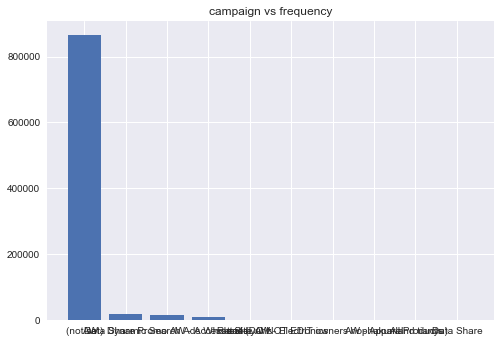

campaignCode


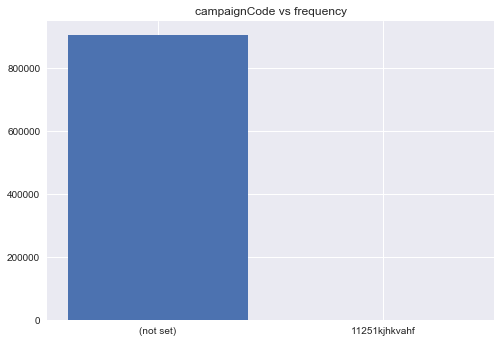

medium


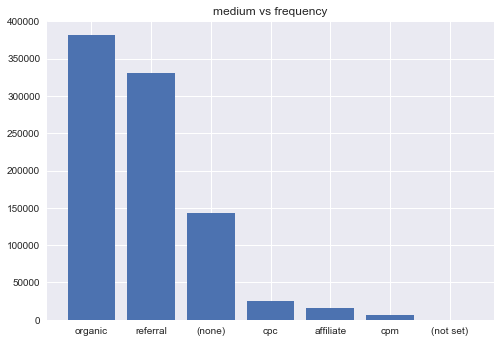

adNetworkType


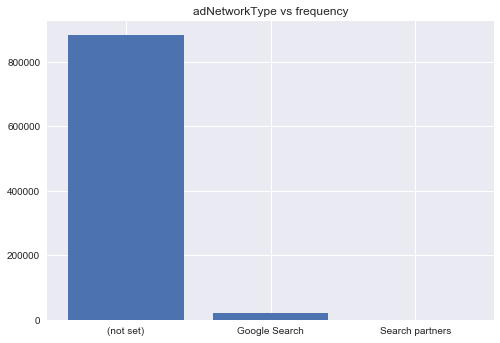

slot


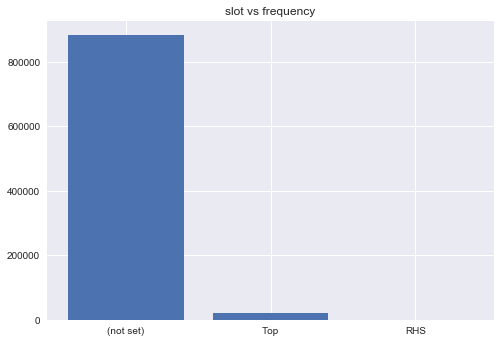

dayNameDate


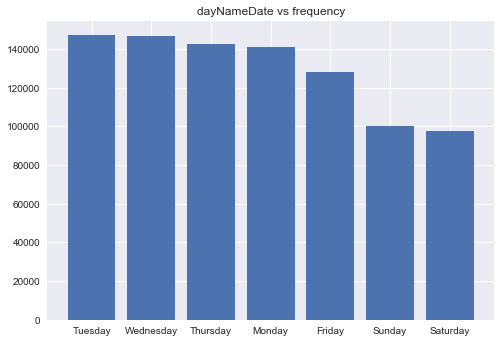

In [102]:
object_cols = train_data_v4.select_dtypes(include='object').columns
for i in object_cols:
    if i != 'fullVisitorId' and i != 'sessionId':
        if train_data_v4[i].nunique() <= 50:
            print(i)
            plot_cat_bar(train_data_v4, i, str(i) + ' vs frequency')
# plt.bar(test.index, test.channelGrouping)

In [59]:
test = pd.DataFrame(train_data_v4['channelGrouping'].value_counts()).reset_index()
test

,index,channelGrouping
0,Organic Search,381561
1,Social,226117
2,Direct,143026
3,Referral,104838
4,Paid Search,25326
5,Affiliates,16403
6,Display,6262
7,(Other),120


Models that I will test out:
    - Logistic Regression
    - Random Forrest
    - Boosting
    - SVM

- Do some eda on counts
- Categorical barplots
- understanding of unique identifier
- build a simple model
    - Build a model to classify data as made transaction or did not make transaction
        - optimize that model and identify if possible to move on to next stage and predict transaction revenue
    - Build model to sum transaction for the specific row using the training data of ones with only transactions
        - identify if this is a better approach then using all models
        
        
        
        
- scatter plots with color

In GA they split session at the midnight in the user timezone to include session in both days, but keep the same sessionId to properly calculate conversions to the Goals. So technically they are one sessions.